In [1]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import SGD, Nadam
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
%matplotlib inline
from utils import *
import os

Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.abspath('./')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base.hdf5')
EXPERIENCE_BUFFER_FILE = os.path.join(DATA_DIR, 'experience_buffer.p')
INPUT_SHAPE = 11

In [3]:
input = np.zeros((15, 15, 27*2))

In [4]:
"""
The input features st are processed by a residual tower that consists of a single
convolutional block followed by either 19 or 39 residual blocks
(1) A convolution of 256 filters of kernel size 3×3 with stride 1
(2) Batch normalization18
(3) A rectifier nonlinearity
Each residual block applies the following modules sequentially to its input:
(1) A convolution of 256 filters of kernel size 3×3 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
(4) A convolution of 256 filters of kernel size 3×3 with stride 1
(5) Batch normalization
(6) A skip connection that adds the input to the block
(7) A rectifier nonlinearity
The output of the residual tower is passed into two separate ‘heads’ for
computing the policy and value. The policy head applies the following modules:
(1) A convolution of 2 filters of kernel size 1×1 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
(4) A fully connected linear layer that outputs a vector of size 192+ 1= 362,
corresponding to logit probabilities for all intersections and the pass move
The value head applies the following modules:
(1) A convolution of 1 filter of kernel size 1×1 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
(4) A fully connected linear layer to a hidden layer of size 256
(5) A rectifier nonlinearity
(6) A fully connected linear layer to a scalar
(7) A tanh nonlinearity outputting a scalar in the range [−1, 1]
"""

'\nThe input features st are processed by a residual tower that consists of a single\nconvolutional block followed by either 19 or 39 residual blocks\n(1) A convolution of 256 filters of kernel size 3\xc3\x973 with stride 1\n(2) Batch normalization18\n(3) A rectifier nonlinearity\nEach residual block applies the following modules sequentially to its input:\n(1) A convolution of 256 filters of kernel size 3\xc3\x973 with stride 1\n(2) Batch normalization\n(3) A rectifier nonlinearity\n(4) A convolution of 256 filters of kernel size 3\xc3\x973 with stride 1\n(5) Batch normalization\n(6) A skip connection that adds the input to the block\n(7) A rectifier nonlinearity\nThe output of the residual tower is passed into two separate \xe2\x80\x98heads\xe2\x80\x99 for\ncomputing the policy and value. The policy head applies the following modules:\n(1) A convolution of 2 filters of kernel size 1\xc3\x971 with stride 1\n(2) Batch normalization\n(3) A rectifier nonlinearity\n(4) A fully connected l

In [5]:
from keras.regularizers import l2
from keras.initializers import RandomNormal
from keras.layers import Add
from keras.layers.advanced_activations import LeakyReLU

W_init = 'glorot_normal' #'glorot_uniform'
b_init = 'zeros'
W_dense_init = W_init

def residual_block(input):
    x = conv_block(input, )
    x = Conv2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, input])
    x = Activation('relu')(x)
    return x

def conv_block(input, padding="same"):
    x = Conv2D(256, (3, 3), padding=padding)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def final_block(input):
    x = Conv2D(2, (1,1))(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dense(1, activation = 'linear')(x)
    return x

INPUT_SHAPE = (15, 15, 27*2)
reg = 1e-2
model_input = Input(shape=INPUT_SHAPE)
x = conv_block(model_input)
for _ in range(5):
    x = residual_block(x)
x = final_block(x)
convnet = Model(inputs = model_input, outputs = x)
print(convnet.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 15, 15, 54)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 15, 15, 256)   124672      input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 15, 15, 256)   1024        conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 15, 15, 256)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [8]:
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape
base_network = convnet
input_a = Input(shape=INPUT_SHAPE)
processed_a = base_network(input_a)
input_b = Input(shape=INPUT_SHAPE)
processed_b = base_network(input_b)
distance = layers.Subtract()([processed_a, processed_b])
out = Activation('sigmoid')(distance)
siamese_net = Model([input_a, input_b], out)
siamese_net.save_weights(INIT_WEIGHTS)
print(siamese_net.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 15, 15, 54)    0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 15, 15, 54)    0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 1)             6152971     input_4[0][0]                    
                                                                   input_5[0][0]                    
____________________________________________________________________________________________________
subtract_1 (Subtract)            (None, 1)             0           model_1[1][0]           

In [6]:
BASE_WEIGHTS = siamese_net.get_weights()
# BASE_WEIGHTS[0][2] = 0.1
# siamese_net.set_weights(BASE_WEIGHTS)
# print(BASE_WEIGHTS)

In [9]:
import cPickle as pickle
MOVES = pickle.load(open("../moves_dict.p", "rb"))

In [10]:
BOARDS = pickle.load(open("../boards_dict.p", "rb"))

In [16]:
import convert_boards; reload(convert_boards)
from convert_boards import convert_boards
boards = convert_boards(BOARDS)

In [20]:
keys = boards.keys()

In [21]:
x1, x2 = boards[keys[0]]
x3 = x2[0]

In [22]:
print(x1.shape)
print(x3.shape)
x4 = np.concatenate((x1,x3), axis = -1)
print(x4.shape)

(15, 15, 27)
(15, 15, 27)
(15, 15, 54)


In [39]:
scores = {k : [i[0] for i in v] for k, v in MOVES.iteritems()}

In [66]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=2, verbose = 1, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=1e-3,
                              patience=15,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [63]:
import utils_board; reload(utils_board)
from utils_board import DataGeneratorTest

# keys_small = keys[:100000]
# board_small = {k : boards[k] for k in keys_small}
# scores_small = {k: scores[k] for k in keys_small}

BATCH_SIZE = 512
EXPERIENCE_BUFFER_FILE = "experience_buffer/test_scores.npz" 
load_from_file = False #os.path.exists(EXPERIENCE_BUFFER_FILE)
save_to_file = False
datagen = DataGeneratorTest(boards, scores, batch_sz = BATCH_SIZE, load_from_file = load_from_file, 
                 save_to_file = save_to_file, file = EXPERIENCE_BUFFER_FILE)

((649143, 15, 15, 54), (649143,))
Train: 636160 Val: 12983


In [64]:
NUM_TRAIN = 636160
NUM_VAL = 12983
STEPS_PER_EPOCH = NUM_TRAIN//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL//BATCH_SIZE

In [70]:
nadam = Nadam(lr=1e-3)
convnet.compile(optimizer=nadam, loss='mse', metrics=['accuracy'])
# convnet.load_weights(INIT_WEIGHTS)

In [ ]:
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
history = convnet.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=250,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/250
  78/1242 [>.............................] - ETA: 13546s - loss: 259.5495 - acc: 0.0340

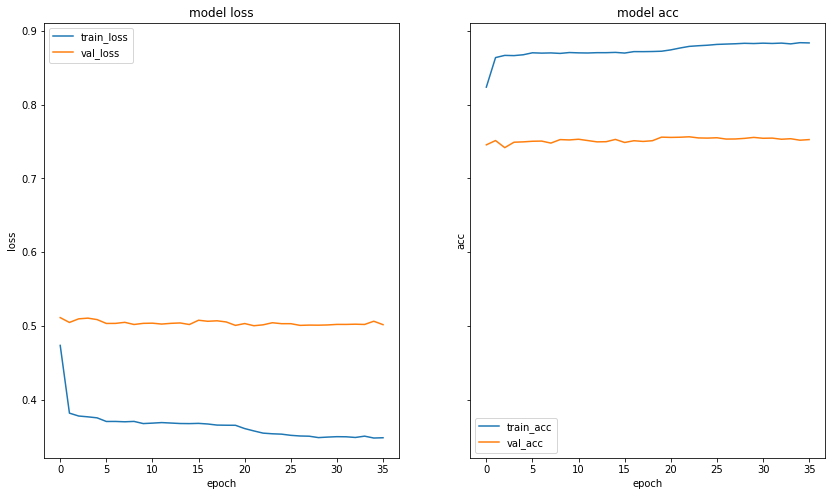

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc', 'val_acc'], loc='lower left')

# plt.show()
f.savefig('results_scores.png')

In [21]:
for i in range(2):
    if i == 0:
        print("Base weights:")
        siamese_net.set_weights(BASE_WEIGHTS)
    else:
        print("Checkpointed weights:")
        siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
    val = siamese_net.evaluate_generator(
            datagen.next_train(),
            steps=STEPS_PER_EPOCH)
    print("Loss: {} Acc: {}".format(val[0], val[1]))

Base weights:
Loss: 0.72213492367 Acc: 0.221307516549
Checkpointed weights:
Loss: 0.508487781731 Acc: 0.749232751861


In [22]:
# siamese_net.set_weights(BASE_WEIGHTS)
siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
SAVE_MODEL = "keras_tensorflow"
model_to_save = siamese_net.layers[2]
model_to_save.summary()
model_to_save.save(SAVE_MODEL, overwrite='True')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x (InputLayer)                   (None, 11)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 8)             96          x[0][0]                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 8)             32          dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8)             0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [23]:
model_to_save.get_weights()

[array([[ -7.77183101e-03,  -7.80454790e-03,  -6.26714388e-03,
           1.05741378e-02,   9.92069021e-03,   1.00576524e-02,
           1.00338655e-02,   9.84100625e-03],
        [ -3.08994926e-03,  -3.22992448e-03,  -3.34323151e-03,
          -7.43953802e-04,  -1.23617181e-04,  -6.85771462e-04,
          -1.16106495e-03,   4.50546213e-04],
        [ -6.50702859e-05,  -3.72116192e-05,  -1.00510602e-04,
           4.91706247e-04,   2.39021159e-04,   3.25150671e-04,
           2.11599501e-04,   2.64863920e-04],
        [  3.64084216e-03,   3.17690801e-03,   3.72944027e-03,
          -2.64052255e-03,  -2.14369525e-03,  -2.05290248e-03,
          -2.41004070e-03,  -3.28733644e-04],
        [  5.01143339e-04,   2.51307758e-03,   1.02558802e-03,
          -7.31383625e-04,  -2.07398625e-04,  -9.87060950e-04,
           7.24000391e-04,  -2.46735901e-04],
        [ -3.60509672e-04,   5.92598633e-04,   1.33060137e-04,
           5.41063841e-04,   2.51443055e-03,   2.81472248e-03,
           1.2

In [24]:
status = os.system("python keras_to_tensorflow.py keras_tensorflow")
if status == 0:
    print("Success")

Success
